In [11]:
import jax
import jax.numpy as jnp
import optax
import sys
sys.path.append('/Users/mariana/Documents/research/xlstm-jax')

# Force CPU (optional)
jax.config.update("jax_platform_name", "cpu")

In [2]:
from dataclasses import dataclass
from flax import linen as nn

from xlstm_jax.models.xlstm_clean.components.init import small_init
from xlstm_jax.models.xlstm_clean.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig
from xlstm_jax.models.xlstm_clean.blocks.mlstm.block import xLSTMBlockConfig, mLSTMBlockConfig
from xlstm_jax.models.xlstm_clean.blocks.mlstm.cell import mLSTMBackendNameAndKwargs
from xlstm_jax.models.xlstm_clean.blocks.mlstm.layer import mLSTMCellConfig, mLSTMLayerConfig
from xlstm_jax.models.xlstm_clean.components.feedforward import FeedForwardConfig

In [5]:
from scipy.special import expit as sigmoid
import numpy as np
import matplotlib.pyplot as plt

In [3]:
@dataclass
class xLSTMTabModelConfig(xLSTMBlockStackConfig):
    embedding_dim: int = 16
    tie_weights: bool = False
    weight_decay_on_embedding: bool = False
    add_embedding_dropout: bool = True
    output_dim: int = 1

class xLSTMTabModel(nn.Module):
    config: xLSTMTabModelConfig

    @nn.compact
    def __call__(self, x: jax.Array, train: bool = False) -> jax.Array:
        x = nn.Dense(
            features=self.config.embedding_dim,
            kernel_init=small_init(self.config.embedding_dim),
            dtype=self.config._dtype,
            name="token_embedding",
        )(x)
        pos_emb = self.param(
            "pos_embedding",
            nn.initializers.normal(stddev=0.02),
            (self.config.context_length, self.config.embedding_dim),
        )
        x = x + pos_emb[:x.shape[1]]
        if self.config.add_embedding_dropout:
            x = nn.Dropout(rate=self.config.dropout)(x, deterministic=not train)
        x = xLSTMBlockStack(config=self.config, name="xlstm_block_stack")(x, train=train)
        logits = nn.Dense(
            features=self.config.output_dim,
            kernel_init=small_init(self.config.embedding_dim),
            use_bias=False,
            dtype=jnp.float32,
            name="pred_head",
        )(x)
        return logits

In [4]:
@dataclass
class ModelConfig:
    batch_size: int = 1
    embedding_dim: int = 16
    num_blocks: int = 2
    num_heads: int = 2
    context_length: int = 32
    backend: str = "parallel_stabilized"
    backend_name: str = ""

cfg = ModelConfig(
    batch_size=16,
)

dtype_str = "float32"
xlstm_config = xLSTMTabModelConfig(
    embedding_dim=cfg.embedding_dim,
    num_blocks=cfg.num_blocks,
    context_length=cfg.context_length,
    tie_weights=False,
    add_embedding_dropout=False,
    add_post_blocks_norm=True,
    dtype="bfloat16",
    mlstm_block=xLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4,
            qkv_proj_blocksize=4,
            num_heads=4,
            proj_factor=2.0,
            embedding_dim=cfg.embedding_dim,
            bias=True,
            dropout=0.2,
            context_length=cfg.context_length,
            dtype="bfloat16",
        ),
        _num_blocks=1,
        _block_idx=0,
        feedforward=FeedForwardConfig(
            proj_factor=4.0,
            embedding_dim=cfg.embedding_dim,
            dropout=0.2,
            dtype="bfloat16",
        ),
    ),
)

In [6]:
# Borrowed from tdsurv (https://github.com/spotify-research/tdsurv/blob/main/notebooks/random-walk-final.ipynb)
def make_generator(mat, sigma, sigma0, thetas, bias, rng):
    """Sample from a Gauss-Markov process.
    
    Initial state:
    
        x_0 = noise(sigma0)
    
    Transition dynamics:
    
        x_nxt = np.dot(mat, x) + noise(sigma)
        
    Churn probability:
    
        p = sigmoid(np.dot(x, thetas) + bias)
    """
    n_dims = mat.shape[0]
    def gen(n_samples, horizon):
        seqs = np.zeros((n_samples, horizon + 1, n_dims + 1))
        ts = np.zeros(n_samples, dtype=int)
        cs = np.zeros(n_samples, dtype=bool)
        for i in range(n_samples):
            seqs[i, 0] = np.append(sigma0 * rng.normal(size=n_dims), 1)
            ts[i] = 1
            for j in range(0, horizon):
                p = sigmoid(np.dot(seqs[i, j, :-1], thetas) + bias)
                if rng.uniform() < p:
                    break
                ts[i] += 1
                seqs[i, j + 1] = np.append(
                    np.dot(mat, seqs[i, j, :-1]) + sigma * rng.normal(size=n_dims),
                    1,
                )
            if ts[i] > horizon:
                ts[i] = horizon
                cs[i] = True
        return seqs.astype(np.float32), ts, cs
    return gen

In [7]:
rng = np.random.default_rng(seed=0)

n_dims = 1
horizon = 99
d = n_dims
H = horizon 

# Churn parameters.
thetas = rng.normal(size=n_dims)
bias = -4

# Transition dynamics.
mat = 1.0 * np.eye(n_dims)
sigma = 0.5
sigma0 = 1.0 # Affect results quite a lot


gen = make_generator(mat, sigma, sigma0, thetas, bias, rng)
seqs, ts, cs = gen(n_samples=1000, horizon=horizon)

In [8]:
seqs.shape

(1000, 100, 2)

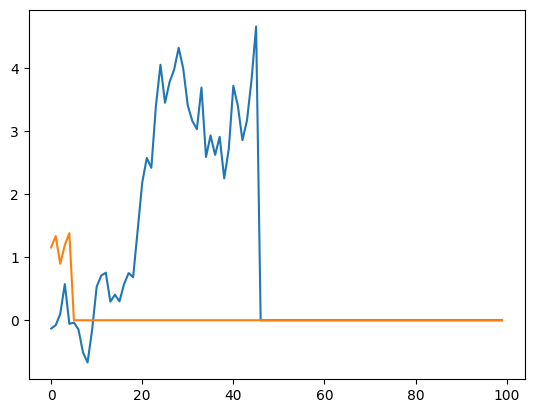

In [9]:
plt.plot(seqs[0][:,0])
plt.plot(seqs[10][:,0])

In [10]:
cs.sum()/len(cs)

0.188

In [13]:
# Training setup

S = 32  # context length (fixed for the model)

# Dataset: generate long sequences and chunk them with sliding window
class ChunkedDataset:
    """Generate long sequences and yield chunks via sliding window."""
    
    def __init__(self, gen_fn, n_seqs=100, horizon=200, chunk_size=32, stride=1):
        self.gen_fn = gen_fn
        self.chunk_size = chunk_size
        self.stride = stride
        self.refresh(n_seqs, horizon)
    
    def refresh(self, n_seqs=100, horizon=200):
        """Generate new sequences and extract chunks."""
        seqs, _, _ = self.gen_fn(n_samples=n_seqs, horizon=horizon)
        self.all_chunks_x = []
        self.all_chunks_mask = []
        
        for i in range(len(seqs)):
            seq_x = seqs[i, :, :1]      # (L, 1) - values
            seq_mask = seqs[i, :, -1]   # (L,) - validity mask
            valid_len = int(seq_mask.sum())
            
            # Extract chunks using sliding window (only from valid region)
            for start in range(0, max(1, valid_len - self.chunk_size + 1), self.stride):
                end = start + self.chunk_size
                if end <= valid_len:
                    self.all_chunks_x.append(seq_x[start:end])
                    self.all_chunks_mask.append(seq_mask[start:end])
        
        self.all_chunks_x = np.array(self.all_chunks_x)      # (N_chunks, chunk_size, 1)
        self.all_chunks_mask = np.array(self.all_chunks_mask) # (N_chunks, chunk_size)
        print(f"Created {len(self.all_chunks_x)} chunks from {n_seqs} sequences")
    
    def sample_batch(self, batch_size, rng_key=None):
        """Sample a random batch of chunks."""
        if rng_key is None:
            idx = np.random.choice(len(self.all_chunks_x), size=batch_size, replace=True)
        else:
            idx = jax.random.choice(rng_key, len(self.all_chunks_x), shape=(batch_size,), replace=True)
        return self.all_chunks_x[idx], self.all_chunks_mask[idx]

# Create dataset
dataset = ChunkedDataset(gen, n_seqs=200, horizon=150, chunk_size=S, stride=1)

# Initialize model
xlstm = xLSTMTabModel(config=xlstm_config)
rng = jax.random.PRNGKey(42)
param_rng, dropout_rng = jax.random.split(rng)
params = xlstm.init({"params": param_rng, "dropout": dropout_rng}, jnp.ones((1, S, 1)))

Created 5372 chunks from 200 sequences


In [14]:
# Loss: MSE for next-token prediction with padding mask
def loss_fn(params, x, mask, rng):
    """
    x: (B, S, 1) - input sequence of EXACTLY context_length
    mask: (B, S) - 1 where valid, 0 where padded
    
    Next-token prediction: pred[t] predicts x[t+1]
    Loss computed only where BOTH input[t] AND target[t+1] are valid.
    
    Example with padding=3:
      Input:  [0,   0,   0,   x_0, x_1, x_2, x_3, x_4]
      Target: [0,   0,   x_0, x_1, x_2, x_3, x_4, ???]  (shifted)
      Mask:   [0,   0,   0,   1,   1,   1,   1,   1]
      
      Loss only at positions 3-6 where input is valid:
        - pos 3: given x_0, predict x_1
        - pos 4: given x_0,x_1, predict x_2
        - etc.
    """
    preds = xlstm.apply(params, x, train=True, rngs={"dropout": rng})  # (B, S, 1)
    
    # Masks for valid positions
    input_mask = mask[:, :-1]   # (B, S-1) - is input at position t valid?
    target_mask = mask[:, 1:]   # (B, S-1) - is target at position t+1 valid?
    combined_mask = input_mask * target_mask  # both must be valid
    
    squared_errors = (preds[:, :-1, 0] - x[:, 1:, 0]) ** 2  # (B, S-1)
    masked_errors = squared_errors * combined_mask
    
    # Mean over valid positions only
    return jnp.sum(masked_errors) / (jnp.sum(combined_mask) + 1e-8)

# Training step
@jax.jit
def train_step(params, opt_state, x, mask, rng):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, mask, rng)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [15]:
# Simple training loop (no random left-padding)
n_steps = 500
batch_size = 32
rng = jax.random.PRNGKey(0)

for step in range(n_steps):
    # Sample batch of full chunks from dataset
    x_batch, mask_batch = dataset.sample_batch(batch_size)
    x_batch = jnp.array(x_batch)
    mask_batch = jnp.array(mask_batch)
    
    rng, step_rng = jax.random.split(rng)
    params, opt_state, loss = train_step(params, opt_state, x_batch, mask_batch, step_rng)
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.6f}")

Step 0, Loss: 17.123051
Step 100, Loss: 5.455016
Step 200, Loss: 0.626931
Step 300, Loss: 0.324258
Step 400, Loss: 1.473301


In [16]:
# Causality test: verify no future leakage
# If we change future values, predictions at earlier timesteps should NOT change

def test_no_future_leakage():
    """
    Test that predictions at time t don't depend on inputs at time > t.
    This verifies the model is truly causal (no information leakage from the future).
    """
    seqs_test, _, _ = gen(n_samples=1, horizon=S)
    x_orig = jnp.array(seqs_test[:, :S, :1])  # (1, S, 1) - exactly context_length
    
    # Get predictions with original input
    preds_orig = xlstm.apply(params, x_orig, train=False)
    
    # Modify future values (last 10 timesteps) with a large perturbation
    x_modified = x_orig.at[:, -10:, :].set(x_orig[:, -10:, :] + 100.0)
    preds_modified = xlstm.apply(params, x_modified, train=False)
    
    # Predictions for early timesteps (before modification) should be IDENTICAL
    # because causal models can only see past, not future
    early_diff = jnp.abs(preds_orig[:, :-10, :] - preds_modified[:, :-10, :]).max()
    
    if early_diff < 1e-5:
        print("✓ Causality test PASSED: No future leakage detected")
        print(f"  Max diff in early predictions: {early_diff:.2e}")
    else:
        print("✗ Causality test FAILED: Future information is leaking!")
        print(f"  Max diff in early predictions: {early_diff:.2e}")
    
    return early_diff < 1e-5

test_no_future_leakage()

✓ Causality test PASSED: No future leakage detected
  Max diff in early predictions: 0.00e+00


Array(True, dtype=bool)

In [17]:
# Evaluation on test set (fresh sequences, not seen during training)
def evaluate(params, gen_fn, n_seqs=50, horizon=150, chunk_size=S):
    """Evaluate model on fresh test sequences."""
    # Generate new test sequences
    test_dataset = ChunkedDataset(gen_fn, n_seqs=n_seqs, horizon=horizon, 
                                   chunk_size=chunk_size, stride=chunk_size)
    
    x_test = jnp.array(test_dataset.all_chunks_x)
    mask_test = jnp.array(test_dataset.all_chunks_mask)
    
    preds = xlstm.apply(params, x_test, train=False)
    
    # Masked test loss (same logic as training: both input AND target must be valid)
    input_mask = mask_test[:, :-1]
    target_mask = mask_test[:, 1:]
    combined_mask = input_mask * target_mask
    
    squared_errors = (preds[:, :-1, 0] - x_test[:, 1:, 0]) ** 2
    test_loss = jnp.sum(squared_errors * combined_mask) / (jnp.sum(combined_mask) + 1e-8)
    
    return test_loss, x_test, mask_test, preds

test_loss, x_test, mask_test, preds_test = evaluate(params, gen)
print(f"Test MSE: {test_loss:.6f}")

Created 48 chunks from 50 sequences
Test MSE: 0.292429


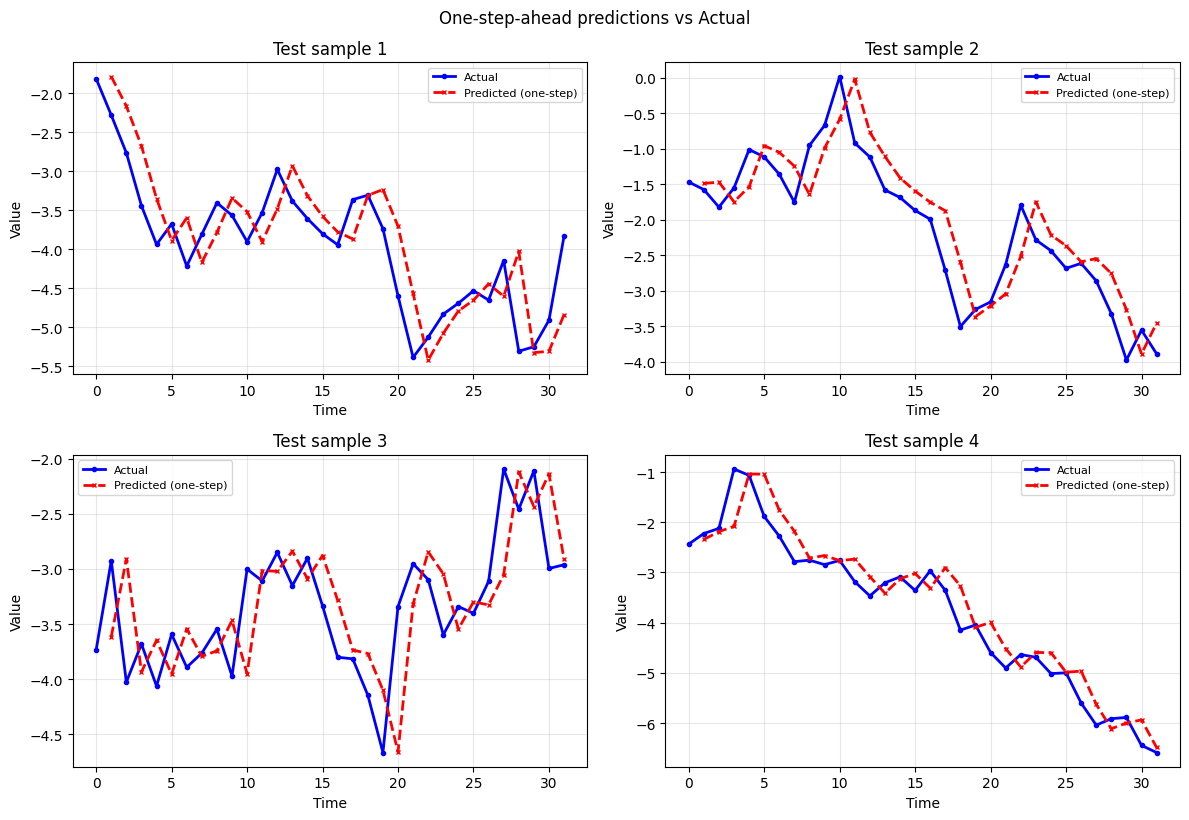

In [18]:
# Simple plot: one-step-ahead predictions vs actual (using full S context)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get a test chunk (full S length)
    seq = np.array(x_test[i, :, 0])
    pred = np.array(preds_test[i, :, 0])
    
    t = np.arange(S)
    
    # Plot actual sequence
    ax.plot(t, seq, 'b-', linewidth=2, label='Actual', marker='o', markersize=3)
    
    # Plot one-step-ahead predictions (pred[t] predicts seq[t+1])
    # So we plot pred[:-1] at positions t+1
    ax.plot(t[1:], pred[:-1], 'r--', linewidth=2, label='Predicted (one-step)', marker='x', markersize=3)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Test sample {i+1}')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('One-step-ahead predictions vs Actual', y=1.02)
plt.show()

In [21]:
x_test.shape

(48, 32, 1)

In [22]:
preds_test.shape

(48, 32, 1)

In [46]:
# Autoregressive forecasting with GROUND TRUTH comparison
def autoregressive_forecast(params, initial_context, max_new_tokens):
    """
    Given initial_context of shape (B, S, 1), autoregressively predict max_new_tokens steps.
    Uses sliding window: always keep the last S values as input.
    
    Returns: (B, S + max_new_tokens, 1) - initial context + predictions
    """
    B = initial_context.shape[0]
    predictions = jnp.zeros((B, max_new_tokens, 1))
    predictions = jnp.concatenate([initial_context, predictions], axis=1)
    # predictions shape: (B, S + max_new_tokens, 1)
    
    for i in range(max_new_tokens):
        # Sliding window of size S: positions i to i+S
        ctx = predictions[:, i:i + S, :]
        pred = xlstm.apply(params, ctx, train=False)
        next_val = pred[:, -1, :]  # shape (B, 1) - prediction at last position
        # Write to position i + S (next position after the context window)
        predictions = predictions.at[:, i + S, :].set(next_val)
    
    return np.array(predictions)


In [47]:
# Generate LONG test sequences (not chunked!) so we have ground truth continuation
n_future = 20
test_seqs, _, _ = gen(n_samples=batch_size, horizon=S + n_future + 10)  # Long enough for context + forecast

In [48]:
initial_context = test_seqs[:, :S, :1]
initial_context.shape

(32, 32, 1)

In [49]:
forecast = autoregressive_forecast(params, initial_context, max_new_tokens=60)

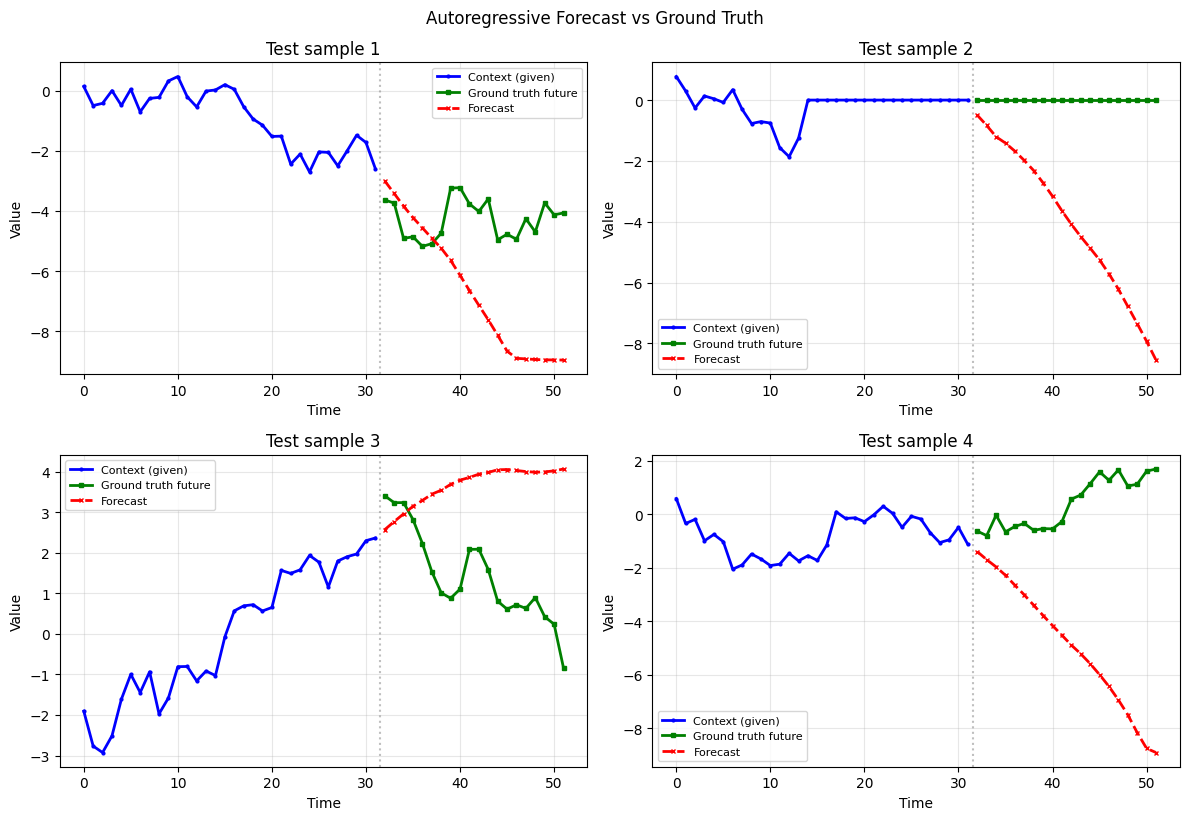

In [50]:
# Plot forecast vs ground truth
n_plot = min(n_future, forecast.shape[1] - S, test_seqs.shape[1] - S)  # How many future steps to plot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Time indices
    t_context = np.arange(S)
    t_future = np.arange(S, S + n_plot)
    
    # Context (first S steps)
    ax.plot(t_context, test_seqs[i, :S, 0], 'b-', linewidth=2, label='Context (given)', marker='o', markersize=2)
    
    # Ground truth future
    ax.plot(t_future, test_seqs[i, S:S+n_plot, 0], 'g-', linewidth=2, label='Ground truth future', marker='s', markersize=3)
    
    # Forecast (squeeze out the last dimension if needed)
    forecast_vals = forecast[i, S:S+n_plot, 0] if forecast.ndim == 3 else forecast[i, S:S+n_plot]
    ax.plot(t_future, forecast_vals, 'r--', linewidth=2, label='Forecast', marker='x', markersize=3)
    
    ax.axvline(x=S-0.5, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Test sample {i+1}')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Autoregressive Forecast vs Ground Truth', y=1.02)
plt.show()

In [43]:
test_seqs[0].shape, forecast[0].shape

((63, 2), (92, 1))

In [25]:
pred = xlstm.apply(params, context, train=False)

In [30]:
context.shape

(1, 32, 1)